In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid', {'font.size': '20.'})

from zoobot.active_learning.analysis import smooth_loss
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
def load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=False, frac=0.01, metric_name='loss'):

    dfs = []
    steps_since_iteration_1_start = 0
    for iteration_n in np.arange(1, n_iterations+1):
        log_name = '{}_iteration_{}_estimators_models_model_{}_log_tensorboard_validation-tag-epoch_loss.csv'.format(run_name, iteration_n, model_n)
        loc = os.path.join(results_dir, log_name)
        iteration_df = pd.read_csv(loc, usecols=['Step', 'Value'])
        iteration_df['iteration'] = iteration_n 
        iteration_df['iteration_step'] = iteration_df['Step']
        iteration_df['global_step'] = iteration_df['iteration_step'] + steps_since_iteration_1_start 
        steps_since_iteration_1_start = iteration_df['global_step'].max()

        smoothed_metric = sm.nonparametric.lowess(
            iteration_df['Value'],
            iteration_df['iteration_step'],
            is_sorted=True, 
            frac=frac)  # controls how much smoothing
        iteration_df['smoothed_{}'.format(metric_name)] = smoothed_metric[:, 1]

        
        dfs.append(iteration_df)
        
    flat_df = pd.concat(dfs)
    flat_df[metric_name] = flat_df['Value']
    del flat_df['Value']
    del flat_df['Step'] 
    flat_df['run_name'] = run_name
    if ('active' in run_name) or ('mutual' in run_name):
        flat_df['acquisition'] = 'active'
    else:
        flat_df['acquisition'] = 'baseline'

    return flat_df

In [5]:


# results_dir = 'results/al_experiment_gz2_m2_3it_partialq'


save_dir = 'results/temp'

n_iterations = 2
n_models = 3

In [6]:
eval_loss_frac = 0.015

In [10]:
results_dir = 'results/gz2_allq_opt4'
active_eval_dfs = []
# run_name = 'run-latest_dirichlet_unfiltered_active_m3_warm'
run_name = 'run-gz2_all_q_opt4_warm_active'
for model_n in range(n_models):
        active_eval_dfs.append(load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=True, frac=eval_loss_frac))

results_dir = 'results/al_experiment_gz2_m3_allq'
baseline_eval_dfs = []
# run_name = 'run-latest_dirichlet_unfiltered_baseline_m3_warm'
run_name = 'run-gz2_all_q_warm_baseline'
for model_n in range(n_models):
        baseline_eval_dfs.append(load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=True, frac=eval_loss_frac))
        

eval_dfs = active_eval_dfs

In [11]:
active_eval_dfs[0]

,iteration,iteration_step,global_step,smoothed_loss,loss,run_name,acquisition
0,1,0,0,1.869698,1.869698,run-gz2_all_q_opt4_warm_active,active
1,1,1,1,1.874103,1.874103,run-gz2_all_q_opt4_warm_active,active
2,1,2,2,1.859245,1.859245,run-gz2_all_q_opt4_warm_active,active
3,1,3,3,1.838126,1.838126,run-gz2_all_q_opt4_warm_active,active
4,1,4,4,1.879549,1.879549,run-gz2_all_q_opt4_warm_active,active
5,1,5,5,1.838375,1.838375,run-gz2_all_q_opt4_warm_active,active
6,1,6,6,1.850851,1.850851,run-gz2_all_q_opt4_warm_active,active
7,1,7,7,1.843959,1.843959,run-gz2_all_q_opt4_warm_active,active
8,1,8,8,1.862301,1.862301,run-gz2_all_q_opt4_warm_active,active
9,1,9,9,1.838108,1.838108,run-gz2_all_q_opt4_warm_active,active


In [12]:

eval_loss_df = pd.concat(eval_dfs).sort_values('global_step').reset_index()
active_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'active'].groupby('global_step').agg('mean').reset_index()
# baseline_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

In [13]:
active_eval_loss_g

,global_step,index,iteration,iteration_step,smoothed_loss,loss
0,0,0.0,1.0,0.0,1.856916,1.856916
1,1,1.0,1.0,1.0,1.870485,1.870485
2,2,2.0,1.0,2.0,1.855154,1.855154
3,3,3.0,1.0,3.0,1.842063,1.842063
4,4,4.0,1.0,4.0,1.871242,1.871242
5,5,5.0,1.0,5.0,1.842478,1.842478
6,6,6.0,1.0,6.0,1.853270,1.853270
7,7,7.0,1.0,7.0,1.841522,1.841522
8,8,8.0,1.0,8.0,1.845649,1.845649
9,9,4.5,1.5,4.5,1.840224,1.840224


In [14]:
iteration_changes = active_eval_loss_g.groupby('iteration').agg({'global_step': 'min'}).reset_index()
iteration_changes

,iteration,global_step
0,1.0,0
1,1.5,9
2,2.0,10


Text(0, 0.5, 'Loss (Smoothed)')

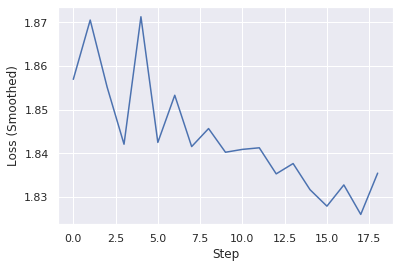

In [15]:
fig, ax = plt.subplots()
ax.plot(active_eval_loss_g['global_step'], active_eval_loss_g['loss'], label='Active')
# ax.plot(baseline_eval_loss_g['step'], baseline_eval_loss_g['smoothed_loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Smoothed)')
# if question == 'smooth':
#     ax.set_ylim([20, 25])
# if question == 'bar':
#     ax.set_ylim([10, 18])
# for step in acq_steps:
#     ax.axvline(step, alpha=0.2, color='k')
# ax.legend()

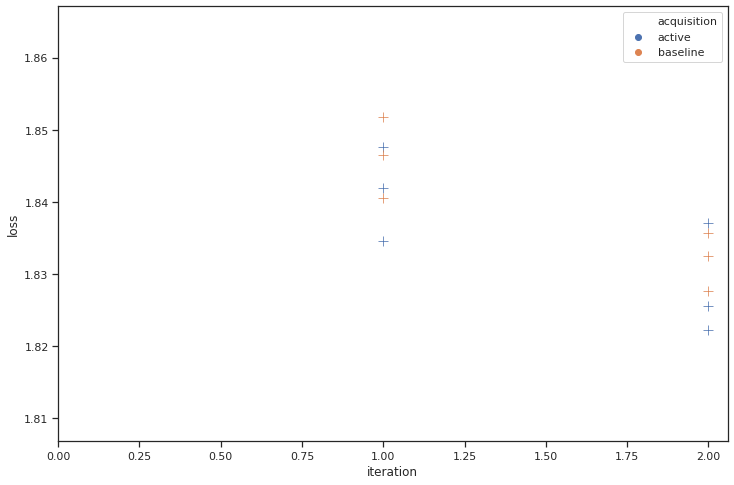

In [16]:
sns.set_style('ticks')
sns.set_context('notebook')
def mean_of_lowest_n(x, n=5):
    return np.sort(x)[:5].mean()

fig, ax = plt.subplots(figsize=(12, 8))

loss_values = []
for n, df in enumerate(active_eval_dfs):
    losses = df.query('iteration_step > 2').groupby('iteration').agg({'loss': mean_of_lowest_n}).reset_index()
    losses['acquisition'] = 'active'
    losses['model_n'] = n
    loss_values.append(losses)
    
for n, df in enumerate(baseline_eval_dfs):
    losses = df.query('iteration_step > 2').groupby('iteration').agg({'loss': mean_of_lowest_n}).reset_index()
    losses['acquisition'] = 'baseline'
    losses['model_n'] = n
    loss_values.append(losses)
    
loss_values = pd.concat(loss_values)
    
loss_values['galaxies'] = 58531+13653*loss_values['iteration']  # initial count + (per_iter * n_iters)
# sns.lineplot(data=loss_values, x='iteration', y='loss', hue='acquisition')
sns.scatterplot(data=loss_values, x='iteration', y='loss', hue='acquisition', marker='+', s=100)
# ax.axhline(1.data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAt4AAAHlCAYAAADCwfusAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nO3de1iUdf7/8ddwUCsgTwjiZB5ScjdPSfLdVVxjdDUNFU07kJrt4halu+qWoa2WmUW1tuuRtDbZPFSrKZKKXGKGmmG6lYe0/LptCIgJmSiKnOb3h1fziy+KowyfQeb5uC6vS+65ue83t7Ozz2v6zI3FbrfbBQAAAKBWebl7AAAAAMATEN4AAACAAYQ3AAAAYADhDQAAABjg4+4BTCguLtaBAwcUGBgob29vd48DAACAeqq8vFwnT57UHXfcoUaNGlV6zCPC+8CBA4qJiXH3GAAAAPAQK1asUFhYWKVtHhHegYGBki5egODgYDdPAwAAgPoqLy9PMTExjv78OY8I75+WlwQHB8tqtbp5GgAAANR3l1rezIcrAQAAAAMIbwAAAMAAwhsAAAAwwCPWeAMAANQXpaWlys7OVnFxsbtH8WiNGjWS1WqVr6+v099DeAMAAFxHsrOz5e/vrzZt2shisbh7HI9kt9tVUFCg7OxstW3b1unvY6kJAADAdaS4uFjNmjUjut3IYrGoWbNmV/1fHQhvAACA6wzR7X7X8m9AeAMAAAAGEN4AAACo0/bv368pU6ZUu096eroSEhIkXVwH/95771V6PDY2VllZWbU2ozMIbwAAANRpnTt31l//+tdq97HZbJo6daokKScnp0p4L126VK1bt661GZ1BeAMAAOCaTZkyRcOHD1dUVJSeeOIJnT59WpK0evVqDRkyREOGDNGIESOUn58vSVqxYoX69++v6Oho/e1vf1N4eLgkKTMzU8OHD3cc9+df//zvBQUFeuSRRxQVFaWoqCjNmTNHkvTBBx9o4sSJkqRZs2bp6NGjGjp0qGNbZGSkvvnmG0nSd999p7FjxyoqKkrR0dHKyMhwnDc0NFSJiYkaMWKEbDabNm/e7LJrxe0EAQAAcM2mT5+upk2bSpJef/11LV26VBEREXrjjTe0cuVKBQYGqqioSD4+Pjp8+LAWL16sdevWqXnz5nruueeu+nwpKSlq3bq1li1bJkmO0P+5GTNmKCEhQR988MElj/HnP/9Zo0aN0siRI/W///u/iomJ0aZNmxw/h5+fn9asWaO9e/fqT3/6kwYMGHDVc14K4Q0AAIBrlpycrJSUFJWWlurcuXNq06aNysvLNXToUAUGBkqSbrrpJknS7t271bdvXzVv3lySdP/992vTpk1Xdb6uXbtq2bJlSkhIUM+ePdW7d++r+v6zZ8/q0KFDGjFihCTptttuU6dOnfTFF18oMjJSkjRo0CBJUrdu3fT999/rwoULatiw4VWd51JYagIAAIBrsmfPHq1atUpvvvmmUlJS9Kc//UklJSXXdCxvb2/Z7XbH1xcuXLjkft27d9fatWt1xx13KDk5WWPGjLmm81Xnp8j29vaWJJWVlbnkuIQ3AAAArklhYaH8/PzUuHFjlZSUaM2aNZKkvn37Kjk52bGuu6ioSBcuXFDPnj318ccfq6CgQNLFdeA/ueWWW3Ts2DGdPn1adrtdGzZsuOQ5jx07Jj8/Pw0ePFjx8fE6ePCgKioqKu3j5+ens2fPXvL7/fz81KlTJ61du1aSdPToUR0+fFjdunWr2cVwAktNAAAAcE0iIiK0fv16DRgwQE2aNFFYWJj279+v8PBwjR8/XuPGjZPFYlGDBg2UmJio22+/XY899pgefPBB+fn5qU+fPo5jBQUFady4cRo+fLiaN2+uu+66S0eOHKlyzt27d2vZsmXy8vJSRUWFnn/+eXl5VX4vOTQ0VG3bttW9996rdu3aad68eZUef+211zRjxgwtW7ZMPj4+euWVVxzru2uTxf7z9/TrqezsbNlsNqWnp8tqtbp7HAAAgGt26NAhderUyd1juER2drZGjBihzMxMd49yTS71b1Fdd7LUBAAAADCA8AYAAIBbWK3W6/bd7mtBeAMAAAAGEN4AAACAAYQ3AAAAYADhDQAAABhAeAMAAAAGEN4AAAAworCwUEuXLq20bfr06dqzZ4+bJjKL31wJAABQz23be0z/3HRI+afOq3mTGzTmnk7q2+MW43MUFhbqzTffVGxsrGPbiy++aHwOd+EdbwAAgHps295jWvCvL3Xy1HnZJZ08dV4L/vWltu095pLjT5kyRcOHD1dUVJSeeOIJnT59WpK0evVqDRkyREOGDNGIESOUn5+vWbNm6cyZMxo6dKgeeOABSdLo0aP10UcfKTc3V7169VJpaanj2BMnTtTatWslSR9//LEeeOABDR8+XPfff7+++OILl8xvEu94AwAA1GP/3HRIF0rLK227UFquf2465JJ3vadPn66mTZtKkl5//XUtXbpUEREReuONN7Ry5UoFBgaqqKhIPj4+mjFjhkaMGKHk5OQqxwkJCVGHDh2UkZEhm82mU6dOKTMzUy+//LKysrK0aNEivfXWW/Lz89ORI0cUGxurbdu21Xh+kwhvAACAeiz/1Pmr2n61kpOTlZKSotLSUp07d05t2rRReXm5hg4dqsDAQEnSTTfd5NSxoqOjtXbtWtlsNn344YeKjIzUjTfeqO3btysrK0sxMTGOfcvKypSfn6/mzZu75OcwgfAGAACox5o3uUEnLxHZzZvcUONj79mzR6tWrdK7776rpk2bKiUlRe+///41H++3v/2tXnrpJZ06dUpr167VtGnTHI9FRETolVdeqfHM7sQabwAAgHpszD2d1NDXu9K2hr7eGnNPpxofu7CwUH5+fmrcuLFKSkq0Zs0aSVLfvn2VnJys/Px8SVJRUZEuXLggPz8/FRcXq6ys7JLHu+GGG2Sz2TR37lydPXtWYWFhkqRevXpp+/btOnLkiGPfffv21Xh+03jHGwAAoB77aR13bdzVJCIiQuvXr9eAAQPUpEkThYWFaf/+/QoPD9f48eM1btw4WSwWNWjQQImJiWrevLmioqIUFRWlm2++We+++26VY0ZHRysmJkZ//OMfHdvatGmjV199VdOnT1dxcbFKS0t15513qkuXLjX+GUyy2O12u7uHqG3Z2dmy2WxKT0+X1Wp19zgAAADX7NChQ+rUqebvVqPmLvVvUV13stQEAAAAMIDwBgAAAAwgvAEAAAADCG8AAADAAMIbAAAAMIDwBgAAAAwgvAEAAHDNQkNDVVRUVOvneeaZZ7R8+XJJ0qpVq7Rs2bJaP6er8Qt0AAAA6rkzBzJ06qMVKisskE9AMzW5O0b+d/Rx91jX7MEHH3T3CNeE8AYAAKjHzhzIUP6GRNnLLkiSygrzlb8hUZJcFt9vvfWW0tPTVVxcrMmTJ2vAgAGSpClTpujbb79VaWmpWrdurTlz5ujmm2/Wf/7zH8XHx+v8+fOqqKhQdHS0fve736mkpESvv/66PvvsM5WUlCg0NFTPPfecbrrppkrnmz9/vs6dO6epU6fqgw8+0IcffqiAgAAdOXJE/v7+mj9/vgIDAyVJS5YsUVpamsrLyxUUFKQXXnjB8ZhpLDUBAACox059tMIR3T+xl13QqY9WuOwcXl5eSk5O1uLFizVjxgwVFBRIkqZPn64PPvhAKSkpuu2227R06VJJ0sqVKxUZGan169frww8/1H333SdJevPNN+Xv76/Vq1dr/fr1atGihZYsWXLF8+/fv19Tp07Vhg0bdNtttzmWpCQnJ+vYsWN6//33tXbtWvXp00cvv/yyy37uq8U73gAAAPVYWWHBVW2/FiNHjpQktWvXTr/4xS/0xRdfyGazKTk5WSkpKSotLdW5c+fUpk0bSdJdd92lV199VefPn1d4eLj+53/+R5K0detWnT17Vps3b5YklZSU6Pbbb7/i+e+88061bNlSktS1a1d98sknjuMdOHBA0dHRkqTy8nL5+fm57Oe+WoQ3AABAPeYT0ExlhfmX3F6b9uzZo1WrVundd99V06ZNlZKSovfff1+SNGDAAHXr1k07d+7U0qVLtWbNGr322muy2+2aOXOmfvWrX13VuRo2bOj4u7e3t8rLyyVJdrtdjz/+uOMddXdjqQkAAEA91uTuGFl8GlbaZvFpqCZ3x7jsHGvWrJEk/fe//9VXX32lbt26qbCwUH5+fmrcuLFKSkoc+0jSd999p8DAQA0fPlxPPPGE9u/fL0mKjIzUsmXLVFxcLEk6e/asjh49es1zRUZGauXKlTp9+rSki++gHz58+JqPV1O84w0AAFCP/fQBytq8q0l5ebmGDRum8+fPa9asWWrWrJkiIiK0fv16DRgwQE2aNFFYWJgjsDdt2qSUlBT5+vrKYrFo2rRpkqTx48drwYIFuu+++2SxWGSxWPTkk0+qffv21zTXsGHD9OOPP+rhhx+WdPEd8AcffNCp5Su1wWK32+1uObNB2dnZstlsSk9Pl9Vqdfc4AAAA1+zQoUPq1KmTu8eALv1vUV13stQEAAAAMIDwBgAAAAwgvAEAAAADCG8AAIDrjAd8RK/Ou5Z/A8IbAADgOtKoUSMVFBQQ325kt9tVUFCgRo0aXdX3cTtBAACA64jValV2drZOnjzp7lE8WqNGja76bnmENwAAwHXE19dXbdu2dfcYuAYsNQEAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADDAyC/QSUhI0ObNm5WTk6OUlBR17Nixyj4FBQWKj4/X8ePHVVZWpvDwcD377LPy8bk44saNG7V48WLZ7XZZLBa9/fbbat68uYnxAQAAgBozEt42m01jxoxRTEzMZfdJTExU+/bttWTJEpWWluqhhx5SWlqaBg0apP3792vBggVKSkpSYGCgzpw5owYNGpgYHQAAAHAJI+EdFhZ2xX0sFouKiopUUVGhkpISlZaWKigoSJK0bNkyPfroowoMDJQk+fv7X/Y4hYWFKiwsrLQtLy+vBtMDAAAANWckvJ0RFxenCRMmqHfv3jp//rxiYmLUo0cPSdLRo0dltVoVExOjc+fOqX///nr88cdlsViqHCcpKUkLFiwwPT4AAABQrToT3qmpqQoNDVVSUpKKiooUGxur1NRUDRw4UOXl5fr666/19ttvq6SkRL///e8VEhKiYcOGVTnO2LFjFR0dXWlbXl5etctcAAAAgNpWZ+5qsnz5cg0ZMkReXl7y9/dXZGSkMjMzJUkhISEaOHCgGjRoID8/P9lsNu3bt++SxwkICJDVaq30Jzg42OSPAgAAAFRRZ8LbarUqIyNDklRSUqJdu3apQ4cOkqR7771XO3bskN1uV2lpqT799FPdfvvt7hwXAAAAuCpGwnv27Nnq06eP8vLyNG7cOA0ePFiSFBsbq/3790uSpk2bpr179yoqKkrDhg1TmzZtNGrUKEnS4MGD1axZMw0aNEjDhg3Tbbfdpvvuu8/E6AAAAIBLWOx2u93dQ9S27Oxs2Ww2paeny2q1unscAAAA1FPVdWedWWoCAAAA1GeENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAAAAgAGENwAAAGAA4Q0AAAAYQHgDAAAABhDeAOCBtuzOcvcIAOBxCG8A8EDpewhvADCN8AYAAAAMILwBAAAAAwhvAAAAwAAfdw8AAKhdW3ZnVVnTfeBogeIX7ai0zRbWWv16tjY5GgB4FMIbAOq5fj2rBnX8oh16Ka63myYCAM/EUhMAAADAAMIbAAAAMIDwBgAAAAwgvAHAA9nC+BAlAJhGeAOAB+LuJQBgHuENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4A4AHOvPlVnePAAAeh/AGAA90Zt82d48AAB6H8AYAAAAMILwBAAAAAwhvAAAAwAAfdw8AAKhdZ77cWmVNd3HWQeW+M6PSNv8ufeXfNdLgZADgWQhvAKjn/LtGVgnq3HdmKGT0LDdNBACeiaUmAAAAgAGENwB4oFNnit09AgB4HMIbADzQqTMX3D0CAHgcwhsAPNA3DX7h7hEAwOMQ3gDggY40/KW7RwAAj0N4AwAAAAZwO0EAqOe27M5S+p6sStsOHC1Q/KIdlbbZwlqrX8/WJkcDAI9iLLwTEhK0efNm5eTkKCUlRR07dqyyT0FBgeLj43X8+HGVlZUpPDxczz77rHx8fDR//nytXLlSLVq0kCTdeeedmjlzpqnxAeC61a9n1aCOX7RDL8X1dtNEAOCZjIW3zWbTmDFjFBMTc9l9EhMT1b59ey1ZskSlpaV66KGHlJaWpkGDBkmShg0bpqlTp5oaGQAAAHAZY+EdFhZ2xX0sFouKiopUUVGhkpISlZaWKigo6KrOU1hYqMLCwkrb8vLyruoYAAAAgKvVqTXecXFxmjBhgnr37q3z588rJiZGPXr0cDy+YcMG7dixQ4GBgZowYYK6d+9e5RhJSUlasGCBybEBAACAK6pT4Z2amqrQ0FAlJSWpqKhIsbGxSk1N1cCBA/XAAw/osccek6+vr3bu3Km4uDht3LhRTZo0qXSMsWPHKjo6utK2vLy8ape4AICnsYXxIUoAMK1O3U5w+fLlGjJkiLy8vOTv76/IyEhlZmZKkgIDA+Xr6ytJ6tWrl1q2bKkjR45UOUZAQICsVmulP8HBwUZ/DgCo67h7CQCYV6fC22q1KiMjQ5JUUlKiXbt2qUOHDpKkEydOOPY7dOiQcnJy1LZtW7fMCQAAAFwtY0tNZs+erbS0NOXn52vcuHFq3LixNmzYoNjYWE2cOFGdO3fWtGnTNHPmTEVFRam8vFzh4eEaNWqUJGnu3Lk6ePCgvLy85Ovrq1deeUWBgYGmxgcAAABqxGK32+3uHqK2ZWdny2azKT09XVar1d3jAAAAoJ6qrjvr1FITAAAAoL4ivAEAAAADCG8AAADAAMIbAAAAMIDwBgAAAAwgvAEAAAADCG8AAADAAMIbAAAAMIDwBgAAAAwgvAEAAAADCG8AAADAAMIbAAAAMIDwBgAAAAwgvAEAAAADCG8AAADAAMIbADzQmS+3unsEAPA4hDcAeKAz+7a5ewQA8DiENwAAAGAA4Q0AAAAYQHgDAAAABvi4ewAAQO068+XWKmu6i7MOKvedGZW2+XfpK/+ukQYnAwDPQngDQD3n3zWySlDnvjNDIaNnuWkiAPBMLDUBAAAADCC8AQAAAAMIbwAAAMAAwhsAPJB/l77uHgEAPA7hDQAeiLuXAIB5hDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4A4AHOvPlVnePAAAeh/AGAA90Zt82d48AAB6H8AYAAAAMILwBAAAAAwhvAAAAwAAfdw8AAKhdZ77cWmVNd3HWQeW+M6PSNv8ufeXfNdLgZADgWZwO708//VStWrXSLbfcou+//15//etf5eXlpcmTJyswMPCK35+QkKDNmzcrJydHKSkp6tixY5V9CgoKFB8fr+PHj6usrEzh4eF69tln5ePz/8f8z3/+o+joaD300EOaOnWqs+MDgMfy7xpZJahz35mhkNGz3DQRAHgmp5eaPP/88/L29pZ0MaLLyspksVj0l7/8xanvt9lsWrFihVq1anXZfRITE9W+fXulpKRo/fr1OnjwoNLS0hyPl5eXa+bMmerXr5+zYwMAAAB1gtPveJ84cUIhISEqKyvTjh07tHXrVvn6+ioiIsKp7w8LC7viPhaLRUVFRaqoqFBJSYlKS0sVFBTkeHzJkiXq27evzp07p3Pnzjk7OgAAAOB2Tr/j7efnp/z8fH322Wdq3769brrpJklSWVmZy4aJi4vTt99+q969ezv+9OjRQ5J0+PBh7dixQ4888ki1xygsLFR2dnalP3l5eS6bEQAAALgWTr/j/fDDD+u+++5TaWmppk2bJkn697//rXbt2rlsmNTUVIWGhiopKUlFRUWKjY1VamqqbDab/vKXv+ill15yLHe5nKSkJC1YsMBlMwFAfeTfpa+7RwAAj+N0eI8fP179+/eXt7e3WrduLUkKCgrS7NmzXTbM8uXLNWfOHHl5ecnf31+RkZHKzMxUly5dlJWVpfHjx0u6+K623W7X2bNn9cILL1Q6xtixYxUdHV1pW15enmJiYlw2JwBc77h7CQCYd1W3E2zbtq3j759++qm8vLzUs2dPlw1jtVqVkZGhLl26qKSkRLt27VL//v0VEhKizMxMx37z58/XuXPnLnlXk4CAAAUEBLhsJgAAAMAVnF7j/fDDD2vv3r2SLn7IcfLkyZoyZYoSExOd+v7Zs2erT58+ysvL07hx4zR48GBJUmxsrPbv3y9JmjZtmvbu3auoqCgNGzZMbdq00ahRo672ZwIAAADqHIvdbrc7s2N4eLg++eQTeXt7q3///lq8eLFuuukmPfjgg9q2bVstj1kz2dnZstlsSk9Pl9Vqdfc4AAAAqKeq606nl5pUVFTIYrEoKytLdrtdt912myTp9OnTrp0WAAAAqIecDu8ePXpo1qxZOnnypPr37y9JysrKUpMmTWptOAAAAKC+cHqN90svvaSAgACFhobqySeflHTx17ePGTOm1oYDAAAA6gun3/Fu0qSJJk+eXGlb3759XT0PAAAAUC85/Y53aWmp5s2bJ5vNps6dO8tms2nevHkqKSmpzfkAAACAesHpd7xfffVV7du3T88//7xCQkKUm5urRYsW6ezZs47fZAkAAADg0pwO79TUVCUnJzs+TNmuXTv94he/0NChQwlvAAAA4AqcXmpyudt9O3kbcAAAAMCjOR3eAwcO1OOPP67t27fr6NGjysjI0BNPPKGBAwfW5nwAAABAveD0UpOnnnpKixcv1qxZs/T9998rKChIgwYNUlxcXG3OBwAAANQL1Yb3rl27Kn3ds2dP9ezZs9K2vXv36le/+pXrJwMAAADqkWrDe/r06ZfcbrFYJF1c322xWJSenu76yQAAAIB6pNrw3rp1q6k5AAAAgHrN6Q9XAgAAALh2hDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAIABhDcAAABgAOENAAAAGEB4AwAAAAYQ3gAAAPBoZ74080sjCW8AAAB4tDP7thk5D+ENAAAAGEB4AwAAAAYQ3gAAAIABPu4eAAAAADDlzJdbq6zpLs46qNx3ZlTa5t+lr/y7Rrr03IQ3AAAAPIZ/18gqQZ37zgyFjJ5V6+dmqQkAeKAtu7PcPQIAeBzCGwA8UPoewhsATCO8AQAAAAMIbwAAAHg0/y59jZyH8AYAAIBHc/XdSy6Hu5oAQD23ZXdWlTXdB44WKH7RjkrbbGGt1a9na5OjAYBHIbwBoJ7r17NqUMcv2qGX4nq7aSIA8EwsNQEAAAAMILwBAAAAAwhvAAAAwADCGwA8kC2MD1ECgGmENwB4IO5eAgDmEd4AAACAAYQ3AAAAYADhDQAAABhAeAMAAAAGEN4AAADwaGe+3GrkPIQ3AAAAPNqZfduMnIfwBgAAAAwgvAEAAAADCG8AAADAAB93DwAAAACYcubLrVXWdBdnHVTuOzMqbfPv0lf+XSNdem7CGwAAAB7Dv2tklaDOfWeGQkbPqvVzs9QEAAAAMIDwBgAAAAwgvAEAAAADCG8AAAB4NP8ufY2ch/AGAACAR8u8cJuR8xDeAAAA8Gjpe7KMnIfwBgAAAAwgvAEAAAADCG8AAADAAH5zJQAAADzGlt1ZVdZ0HzhaoPhFOypts4W1Vr+erV16bsIbAAAAHqNfz6pBHb9oh16K613r52apCQAAAGAA4Q0AAAAYYGSpSUJCgjZv3qycnBylpKSoY8eOVfYpKChQfHy8jh8/rrKyMoWHh+vZZ5+Vj4+P1qxZo2XLlsnLy0sVFRUaOXKkxowZY2J0AAAAwCWMvONts9m0YsUKtWrV6rL7JCYmqn379kpJSdH69et18OBBpaWlSZIGDBig9evXKzk5WatWrdLbb7+tw4cPmxgdAAAA9ZwtzLUforwcI+94h4WFXXEfi8WioqIiVVRUqKSkRKWlpQoKCpIk+fn5OfYrLi5WaWmpLBbLJY9TWFiowsLCStvy8vJqMD0AAADqM1ffveRy6sxdTeLi4jRhwgT17t1b58+fV0xMjHr06OF4PD09XXPnzlVWVpamTJmi0NDQSx4nKSlJCxYsMDU2AAAA4JQ6E96pqakKDQ1VUlKSioqKFBsbq9TUVA0cOFDSxeUqNptNubm5euKJJ9SnTx+1a9euynHGjh2r6OjoStvy8vIUExNj5OcAAAAALqXO3NVk+fLlGjJkiLy8vOTv76/IyEhlZmZW2S8kJESdO3fWtm3bLnmcgIAAWa3WSn+Cg4NreXoAAACgenUmvK1WqzIyMiRJJSUl2rVrlzp06CBJOnr0qGO/H374QZmZmZe8MwoAAABQVxlZajJ79mylpaUpPz9f48aNU+PGjbVhwwbFxsZq4sSJ6ty5s6ZNm6aZM2cqKipK5eXlCg8P16hRoyRJ7733nnbu3CkfHx/Z7XY9/PDD6t279n+7EAAAAOAqFrvdbnf3ELUtOztbNptN6enpslqt7h4HAAAA9VR13VlnlpoAAAAA9RnhDQAAABhAeAMAAAAGEN4AAACAAYQ3AAAAYADhDQAAAI925sutRs5DeLR6b7oAABMRSURBVAMAAMCjndm3zch5CG8AAADAAMIbAAAAMIDwBgAAAAzwcfcAAAAAgClnvtxaZU13cdZB5b4zo9I2/y595d810qXnJrwBAADgMfy7RlYJ6tx3Zihk9KxaPzdLTQAAAAADCG8AAADAAMIbAAAAMIDwBgAAgEfz79LXyHkIbwAAAHg0V9+95HIIbwAAAMAAwhsAAAAwgPAGAACAR9uyO8vIeQhvAAAAeLT0PYQ3AAAAUG8Q3gAAAIABhDcAAABggI+7BwAAAABM2bI7q8qa7gNHCxS/aEelbbaw1urXs7VLz014AwAAwGP061k1qOMX7dBLcb1r/dwsNQEAAAAMILwBAADg0U4VFhs5D+ENAAAAj3bqzAUj5yG8AQAA4NGa+Dcych7CGwAAAB6tSUBDI+chvAEAAAADuJ0gAAAAPAb38QYAAAAM4D7eAAAAQD1HeAMAAAAGEN4AAACAAYQ3AAAAPJotzLUforwcwhsAAAAezdV3L7kcwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAwhsAAAAwgPAGAAAADCC8AQAAAAMIbwAAAMAAH1MnSkhI0ObNm5WTk6OUlBR17Nixyj4FBQWKj4/X8ePHVVZWpvDwcD377LPy8fHRwoULtXHjRnl5ecnX11eTJk1SRESEqfEBAACAGjH2jrfNZtOKFSvUqlWry+6TmJio9u3bKyUlRevXr9fBgweVlpYmSerSpYtWr16tlJQUzZkzR5MmTVJxcbGp8QEAAIAaMfaOd1hY2BX3sVgsKioqUkVFhUpKSlRaWqqgoCBJqvTudmhoqOx2u3788UcFBwdXOkZhYaEKCwsrbcvLy3PBTwAAAABcO2Ph7Yy4uDhNmDBBvXv31vnz5xUTE6MePXpU2W/dunVq3bp1leiWpKSkJC1YsMDEuAAAAIDT6lR4p6amKjQ0VElJSSoqKlJsbKxSU1M1cOBAxz67d+/W3//+d/3jH/+45DHGjh2r6OjoStvy8vIUExNTq7MDAAAA1alT4b18+XLNmTNHXl5e8vf3V2RkpDIzMx3h/fnnn+upp57SokWL1K5du0seIyAgQAEBASbHBgAAAK6oTt1O0Gq1KiMjQ5JUUlKiXbt2qUOHDpKkffv2adKkSZo3b55++ctfunNMAAAA4KoZC+/Zs2erT58+ysvL07hx4zR48GBJUmxsrPbv3y9JmjZtmvbu3auoqCgNGzZMbdq00ahRoyRJzz//vIqLizVjxgwNHTpUQ4cO1ddff21qfAAAAKBGLHa73e7uIWpbdna2bDab0tPTZbVa3T0OAAAA6qnqurNOLTUBAAAA6ivCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvAAAAwADCGwAAADCA8AYAAAAMMBLeCQkJioyMVGhoqL755ptL7lNQUKDx48crKipK99xzj5577jmVlZVJknbs2KHhw4frjjvuUEJCgomRAQAAAJcyEt42m00rVqxQq1atLrtPYmKi2rdvr5SUFK1fv14HDx5UWlqaJOmWW27Riy++qN/97ncmxgUAAABczsfEScLCwq64j8ViUVFRkSoqKlRSUqLS0lIFBQVJkm699VZJ0pYtW1RSUlLtcQoLC1VYWFhpW15e3jVODgAAALiGkfB2RlxcnCZMmKDevXvr/PnziomJUY8ePa76OElJSVqwYEEtTAgAAABcuzoT3qmpqQoNDVVSUpKKiooUGxur1NRUDRw48KqOM3bsWEVHR1falpeXp5iYGFeOCwAAAFyVOhPey5cv15w5c+Tl5SV/f39FRkYqMzPzqsM7ICBAAQEBtTQlAAAAcG3qzO0ErVarMjIyJEklJSXatWuXOnTo4OapAAAAANcw8o737NmzlZaWpvz8fI0bN06NGzfWhg0bFBsbq4kTJ6pz586aNm2aZs6cqaioKJWXlys8PFyjRo2SJO3Zs0eTJ0/W2bNnZbfbtWHDBr344ouKiIhw6vzl5eWS+JAlAAAAatdPvflTf/6cxW63200PZNrHH3+s8ePHu3sMAAAAeIgVK1ZUubNfnVnjXZtuueUWSdI///nPau8ljsv76QOqK1asUHBwsLvHuW5xHWuOa1hzXEPX4DrWHNew5riGNefqa1heXq6TJ0/qjjvuqPKYR4R3gwYNJEmtWrWS1Wp18zTXt+DgYK6hC3Ada45rWHNcQ9fgOtYc17DmuIY158pr+NPvoPm/6syHKwEAAID6jPAGAAAADCC8AQAAAAO8n3vuuefcPYQJDRs2VHh4uBo2bOjuUa5bXEPX4DrWHNew5riGrsF1rDmuYc1xDWvO1DX0iNsJAgAAAO7GUhMAAADAAMIbAAAAMIDwBgAAAAy47n+BzrfffqtnnnlGP/74oxo3bqyEhAS1adOm0j7l5eWaPXu2tm/fLovFovHjx2vkyJFXfMxTOHMNFy5cqI0bN8rLy0u+vr6aNGmSIiIiJEnPPPOMPvnkEzVp0kSSNHDgQD3++OOmfwy3cuYazp8/XytXrlSLFi0kSXfeeadmzpwpSTp//rzi4+N18OBBeXt7a+rUqbr77rtN/xhu58x1fPrpp/X11187vv7666+1cOFC2Wy2aq+xJ0hISNDmzZuVk5OjlJQUdezYsco+vB5emTPXkdfE6jlzDXlNrJ4z15DXw+qdOnVKTz/9tLKystSgQQPdeuutmjVrlpo2bVppv+qeby5/Ltqvc6NHj7avW7fObrfb7evWrbOPHj26yj5r1661P/roo/by8nJ7QUGBPSIiwn7s2LErPuYpnLmGGRkZ9nPnztntdrv90KFD9h49etjPnz9vt9vt9qlTp9rfeecdcwPXQc5cw3nz5tlffvnlS37//Pnz7dOnT7fb7Xb7t99+a//1r39tP3v2bO0NXEc5cx1/7tChQ/aePXvaL1y4YLfbq7/GnuCzzz6z5+bm2u+++277119/fcl9eD28MmeuI6+J1XPmGvKaWD1nruHP8XpY1alTp+yffvqp4+uXX37ZHh8fX2W/6p5vrn4uXtdLTQoKCvTVV1/p3nvvlSTde++9+uqrr/TDDz9U2m/jxo0aOXKkvLy81LRpU/Xr10+pqalXfMwTOHsNIyIidMMNN0iSQkNDZbfb9eOPPxqfty5y9hpWZ9OmTbr//vslSW3atNEdd9yhjIyMWpm3rrqW67h69WpFRUWpQYMGpsas08LCwtSyZctq9+H18MqcuY68JlbPmWtYHV4Tr/4a8npYVePGjRUeHu74ulu3bsrNza2yX3XPN1c/F6/r8D5+/LiCgoLk7e0tSfL29laLFi10/PjxKvuFhIQ4vm7ZsqXy8vKu+JgncPYa/ty6devUunVrBQcHO7a9/fbbioqKUlxcnI4ePVrrc9clV3MNN2zYoKioKD366KP6/PPPHdtzc3PVqlUrx9ee9jyUrv65WFJSopSUFI0YMaLS9stdY1zE66Hr8Zp47XhNdA1eD6+soqJCq1atUmRkZJXHqnu+ufq5eN2v8YZZu3fv1t///nf94x//cGybNGmSAgMD5eXlpXXr1un3v/+9tmzZ4ggoXPTAAw/osccek6+vr3bu3Km4uDht3LjRsQ4UV2fLli0KCQlRp06dHNu4xjCN18Rrx/9eXYfXwyt74YUXdOONN+rhhx926xzX9TveLVu21IkTJ1ReXi7p4geDvv/++yr/aaZly5aV/tPC8ePHHe9MVPeYJ3D2GkrS559/rqeeekoLFy5Uu3btHNuDgoLk5XXxqTRs2DCdO3fOo96ZcPYaBgYGytfXV5LUq1cvtWzZUkeOHJEkhYSEKCcnx7Gvpz0Ppat7LkrSmjVrqry7U901xkW8HroOr4k1w2ui6/B6WL2EhAR99913+tvf/ub43+bPVfd8c/Vz8boO72bNmqlTp0768MMPJUkffvihOnXqVOXTqgMHDtS//vUvVVRU6IcfftCWLVs0YMCAKz7mCZy9hvv27dOkSZM0b948/fKXv6z02IkTJxx/3759u7y8vBQUFFT7w9cRzl7Dn1+nQ4cOKScnR23btpV08Xn43nvvSZL++9//av/+/Y47JHgKZ6+jJOXl5Wnv3r2KioqqtL26a4yLeD10DV4Ta47XRNfg9bB6c+fO1YEDB7Rw4cLLrn+v7vnm6ufidf8r448ePapnnnlGhYWFCggIUEJCgtq1a6fY2FhNnDhRnTt3Vnl5uWbNmqWdO3dKkmJjYx0L5at7zFM4cw1HjBihnJycSv/n8corryg0NFSPPPKICgoKZLFY5Ofnp6efflrdunVz409knjPXcOrUqTp48KDj9mMTJ07Ub37zG0nSuXPn9Mwzz+jQoUPy8vLSU089pX79+rn5pzLPmesoSYsXL9Y333yj119/vdL3V3eNPcHs2bOVlpam/Px8NWnSRI0bN9aGDRt4PbxKzlxHXhOr58w15DWxes5cQ4nXw+ocOXJE9957r9q0aaNGjRpJkqxWqxYuXKihQ4dqyZIlCgoKqvb55urn4nUf3gAAAMD14LpeagIAAABcLwhvAAAAwADCGwAAADCA8AYAAAAMILwBAAAAAwhvALhODR48WJmZmW45d25urrp37+74hUcAgCvjdoIAcJ2bP3++vvvuO7322mu1do7IyEjNnj1bv/71r2vtHABQ3/GONwB4uLKyMnePAAAegfAGgOtUZGSkPvroI73xxhvatGmTunfvriFDhkiSzpw5o2nTpql3796KiIjQ66+/7lgW8sEHH+iBBx7QnDlzFB4ervnz5ysrK0tjxoxReHi4wsPDNWXKFBUWFkqSnnrqKeXm5uqxxx5T9+7dtXTpUmVnZys0NNQR7SdOnNBjjz2mnj17qn///nr//fcdc86fP19//OMf9fTTT6t79+4aPHiw9u/fb/hqAYD7Ed4AcB1r2LCh/vCHP+iee+7R559/rvXr10uSnnnmGfn4+CgtLU3r1q3Tzp079a9//cvxffv27dMtt9yinTt36vHHH5fdbtcf/vAHbd++XZs2bVJeXp7mz58vSXr11VcVEhKixMREff7554qNja0yx+TJkxUcHKzt27dr3rx5mjt3rnbt2uV4fOvWrRo8eLD27NmjyMhIvfDCC7V8ZQCg7iG8AaCeyc/P18cff6xp06bpxhtvVLNmzfTII49ow4YNjn1atGih0aNHy8fHR40aNdKtt96qXr16qUGDBmratKnGjRunzz77zKnzHT9+XP/+97/15z//WQ0bNlSnTp00cuRIJScnO/bp0aOHfvOb38jb21tDhw7V4cOHXf5zA0Bd5+PuAQAArpWbm6uysjL17t3bsa2iokItW7Z0fB0cHFzpe/Lz8/Xiiy9qz549Kioqkt1uV0BAgFPn+/7773XzzTfLz8/PsS0kJEQHDhxwfN28eXPH3xs1aqQLFy6orKxMPj783xAAz8ErHgBc5ywWS6Wvg4OD1aBBA3366aeXDdv/+z1z586VxWJRSkqKGjdurC1btmjWrFlOnb9FixY6ffq0zp4964jv48ePKygo6Bp+GgCov1hqAgDXuWbNmiknJ0cVFRWSLoZwr1699PLLL+vs2bOqqKhQVlaWdu/efdljFBUV6cYbb5S/v79OnDihN998s9LjzZs317Fjxy75vS1btlT37t01d+5cXbhwQYcPH9bq1asdH/QEAFxEeAPAdW7gwIGSpPDwcEVHR0uSXnnlFZWWlmrQoEG66667NHHiRJ08efKyx3jyySf11VdfKSwsTOPHj9dvf/vbSo+PHz9eixcvVlhYmN56660q3z937lzl5OQoIiJCTz75pCZMmMA9vwHg/+AX6AAAAAAG8I43AAAAYADhDQAAABhAeAMAAAAGEN4AAACAAYQ3AAAAYADhDQAAABhAeAMAAAAGEN4AAACAAf8Pv5s1BHbd4rUAAAAASUVORK5CYII=975, color='r', linestyle='--', label='Initial, 60k')  # iteration 0 stable val loss by eye. 58,531 galaxies train, 15,000 eval, 110,297 pool, acquire 13,653 (10 shards, top third) per iter
# ax.axhline(1.947, color='g', linestyle='--', label='Final, 210k')  # iteration 0 stable val loss by eye. 209,294 galaxies
ax.set_xlim([0., None])
plt.legend()